<a href="https://colab.research.google.com/github/jialun1221/scRNA-seq/blob/main/RandomForestWithoutPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note** <div>
This notebook is an extension from RandomForest.ipynb. This RF classifier is trained on input that haven't gone through PCA. When checking for `feature_importances_`, it allows the user to see the features (genes) directly. 

####Install pakcages

In [ ]:
!pip3 install torch torchvision matplotlib
!pip3 install --upgrade pillow==8.1.0
#if branch is stable, will install via pypi, else will install from source
import sys
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns

from sklearn import preprocessing 
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [ ]:
import importlib
required_libraries = ['torch', 'torchvision', 'PIL', 'matplotlib', 
                      'numpy', 'pandas']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

#### **Mount your google drive to access file stored there.**
######If accessing the file from local disk, place the file in the same directory as this script, and use the following line of code

```
# PD_astro = sc.read_h5ad("pd_astro.h5ad")
```
Note, the file you load in should be the one generated from running the preprocessing script, which already eliminated some samples (rows). This data matrix should contain only 50 features, and 7491 training samples, stored in 
```
# adata.obsm['X_pca']
``` 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read the preprocessed data that hasn't gone through PCA
adata = scvi.data.read_h5ad("drive/MyDrive/no_pca.h5ad")

In [ ]:
adata #from printed out results, we see no sign of PCA data included.

AnnData object with n_obs × n_vars = 7491 × 3849
    obs: 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell_Subtype', 'Cell_Type', 'disease__ontology_label', 'organ__ontology_label', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mito', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

In [ ]:
adata.var

The file name is pca_in_obsm.h5ad. 
The previous file name (highly variable genes with n_features = 3799 is called pd_astro-2.h5ad (LBD inclusive)

In [ ]:
bdata = scvi.data.read_h5ad("drive/MyDrive/pd_astro-2.h5ad")

In [ ]:
bdata

In [ ]:
bdata.X.shape

(10325, 3799)

In [ ]:
bdata.obsm['X_pca'].shape

(10325, 50)

In [ ]:
bdata.obs.loc[bdata.obs['disease__ontology_label'].str.contains("Lewy body dementia", case=False)]

In [ ]:
bdata.var

####**Select out your training data and labels, slightly modify it for training.**

In [ ]:
adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

Select your X and y directly from adata.obsm and adata.obs.

In [ ]:
X = pd.DataFrame(adata.X)
y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

In [ ]:
# adata.obs['disease__ontology_label'].str.findall("Lewy body dementia")
# adata.obs.loc[adata.obs['disease__ontology_label'].str.contains("Lewy body dementia", case=True)]
# scRNAdf_X = pd.DataFrame(adata.obsm['X_pca'])
# scRNAdf_Y = adata.obs['disease__ontology_label'].reset_index()
# scRNAdf = scRNAdf_X.join(scRNAdf_Y) 
# print(scRNAdf)
# type(scRNAdf)
# no_index = scRNAdf.drop('index', axis=1)
# no_index
# newdf = no_index.drop(index=no_index[no_index['disease__ontology_label'].str.contains('Lewy body dementia')].index)
# newdf["disease__ontology_label"] = newdf["disease__ontology_label"].replace({"normal": "0", "Parkinson disease": "1"})
# newdf
# X = newdf[list(newdf.columns[0:3799])]
# y = newdf['disease__ontology_label']

####**Run the Random Forest Classifier from Scikit Learn**

install packages, and set the seed to get the same result each time.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import scanpy as sc

from torch.utils.data import TensorDataset

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.12.1+cu113
GPU Available: False


In [ ]:
seed = 4321
np.random.seed(seed) # Set the random seed of numpy for the data split.
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Split the data into training and testing set.

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

Fit the model with the training set, with 100 trees.

In [ ]:
forest = RandomForestClassifier(random_state=0,n_estimators = 100)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

Test the model with the testing set. 

In [ ]:
y_pred_test = forest.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_test)

0.8887900355871886

In [ ]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

array([[ 898,  101],
       [ 149, 1100]])

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
matrix

array([[0.8988989 , 0.1011011 ],
       [0.11929544, 0.88070456]])

In [ ]:
!pip install matplotlib==3.1.3 #install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


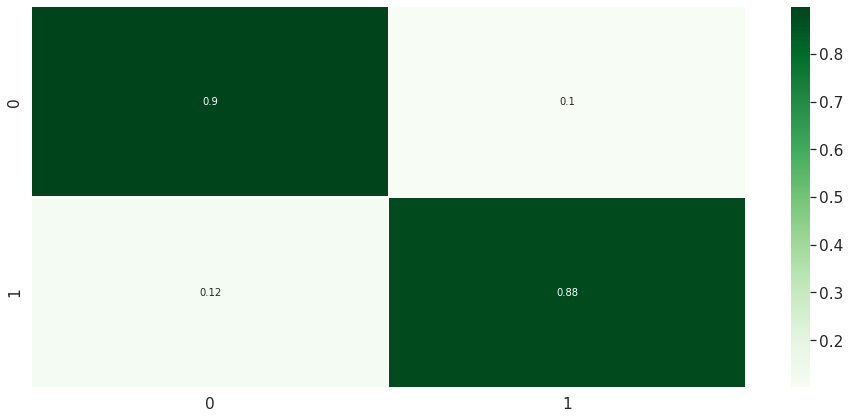

In [ ]:
# Build the confusion matrix plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

In [ ]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       999
           1       0.92      0.88      0.90      1249

    accuracy                           0.89      2248
   macro avg       0.89      0.89      0.89      2248
weighted avg       0.89      0.89      0.89      2248



####**SHAP?**


In [ ]:
!pip install shap
import shap

In [ ]:
# X, y = shap.datasets.boston()

####**Find the most used PCs of the model Part 1.**
This part of code looks at the selected features from the top 10 principle components that are used for Random Forest Classification

---



[Here](https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f) I will do the model fitting and feature selection altogether in one line of code.

*   I specify the random forest instance, indicating the number of trees (n = 100).
*   Then I use [`selectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) object from sklearn to automatically select the features (keeping `max_features=50`).

**Note** <div>
check out from the [sklearn.feature_selection.SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html). The first parameter is passed in as an object, and the second parameter `max_features` controls the max number of features to select. 

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100),max_features=50)

`SelectFromModel `will select those features which importance is greater than the mean importance of all the features by default, but we can alter this threshold if we want. Now, fit the model.

In [ ]:
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(), max_features=50)

 Get the integer index of the features selected. If indices is False, this is a boolean array of shape `[# input features]`, in which an element is True iff its corresponding feature is selected for retention. If indices is True, this is an integer array of shape `[# output features] `whose values are indices into the input feature vector.

To see which features are important we can use `get_support method` on the fitted model. It will return an array of boolean values. True for the features whose importance is greater than the mean importance and False for the rest.

In [ ]:
sel.get_support()

array([False, False, False, ..., False, False, False])

In [ ]:
selected_feat= X_train.columns[(sel.get_support())] #look for indexes selected features in the X_train columns.
print(len(selected_feat)) #gives number of selected features
print(selected_feat) #gives indexes of selected features

50
Int64Index([ 109,  250,  319,  478,  522,  568,  640,  806,  831,  870,  877,
             907,  960, 1166, 1167, 1196, 1326, 1391, 1561, 1578, 1651, 1825,
            1894, 1982, 2031, 2055, 2150, 2205, 2309, 2436, 2438, 2562, 2571,
            2574, 2588, 2593, 2794, 2795, 2806, 3049, 3050, 3051, 3086, 3113,
            3211, 3388, 3498, 3511, 3550, 3671],
           dtype='int64')


Since we have the index of the selected features, we can access the names of these features based on indexes

In [ ]:
names = adata.var_names

In [ ]:
gene_list = []

In [ ]:
for i in selected_feat:
  gene_list.append(names[i])

In [ ]:
print(gene_list)

['DAB1', 'CHI3L1', 'AC012593.1', 'HSPE1-MOB4', 'SERPINE2', 'SLC6A11', 'ADAMTS9-AS2', 'SLC4A4', 'GRID2', 'HSPA4L', 'SLC7A11', 'GALNTL6', 'GPBP1', 'HSPA1A', 'HSPA1B', 'HSP90AB1', 'DGKB', 'HSPB1', 'XIST', 'PLP1', 'PEBP4', 'IARS', 'PTGDS', 'STIP1', 'CHORDC1', 'CRYAB', 'C10orf11', 'BAG3', 'PTGES3', 'HMGB1', 'HSPH1', 'JDP2', 'NRXN3', 'FLRT2', 'MEG3', 'HSP90AA1', 'MT3', 'MT2A', 'GINS3', 'ABHD3', 'MIB1', 'CABLES1', 'ZNF516', 'ACSS1', 'DNAJB1', 'TTTY14', 'SH3BGR', 'MT-CO3', 'AC139100.2', 'RNA28S5']


write output into a csv file. 

In [ ]:
! mkdir write

In [ ]:
import csv
with open('write/gene_list', 'w', encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(gene_list)

In [ ]:
fi = forest.feature_importances_

In [ ]:
type(fi)

numpy.ndarray

In [ ]:
fi.shape

(3849,)

In [ ]:
sel.estimator_ = 3849

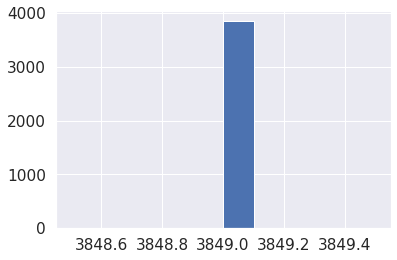

In [ ]:
pd.Series(sel.estimator_,fi.ravel()).hist()

In [ ]:
ser = pd.Series(names, index = selected_feat)

ValueError: ignored

**Write the top 10 gene components of the PCs into a dataframe**

In [ ]:
#To-Do

Rank genes according to contributions to PCs.

####**Find the feature importance of the model Part 2.**
This part of code looks at feature importances using the scikit learn method.

---

In [ ]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
print(feature_names)

['feature 0', 'feature 1', 'feature 2', 'feature 3', 'feature 4', 'feature 5', 'feature 6', 'feature 7', 'feature 8', 'feature 9', 'feature 10', 'feature 11', 'feature 12', 'feature 13', 'feature 14', 'feature 15', 'feature 16', 'feature 17', 'feature 18', 'feature 19', 'feature 20', 'feature 21', 'feature 22', 'feature 23', 'feature 24', 'feature 25', 'feature 26', 'feature 27', 'feature 28', 'feature 29', 'feature 30', 'feature 31', 'feature 32', 'feature 33', 'feature 34', 'feature 35', 'feature 36', 'feature 37', 'feature 38', 'feature 39', 'feature 40', 'feature 41', 'feature 42', 'feature 43', 'feature 44', 'feature 45', 'feature 46', 'feature 47', 'feature 48', 'feature 49', 'feature 50', 'feature 51', 'feature 52', 'feature 53', 'feature 54', 'feature 55', 'feature 56', 'feature 57', 'feature 58', 'feature 59', 'feature 60', 'feature 61', 'feature 62', 'feature 63', 'feature 64', 'feature 65', 'feature 66', 'feature 67', 'feature 68', 'feature 69', 'feature 70', 'feature 71', '

In [ ]:
X.shape[1]

3849

In [ ]:
adata.var[1,:]

TypeError: ignored

In [ ]:
index = X.columns
print(index) #feature name is a list of indexes 

RangeIndex(start=0, stop=3849, step=1)


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_[0:100] #taketake the first 100 importances from the numpy array
print(len(importances))

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

100
Elapsed time to compute the importances: 0.051 seconds


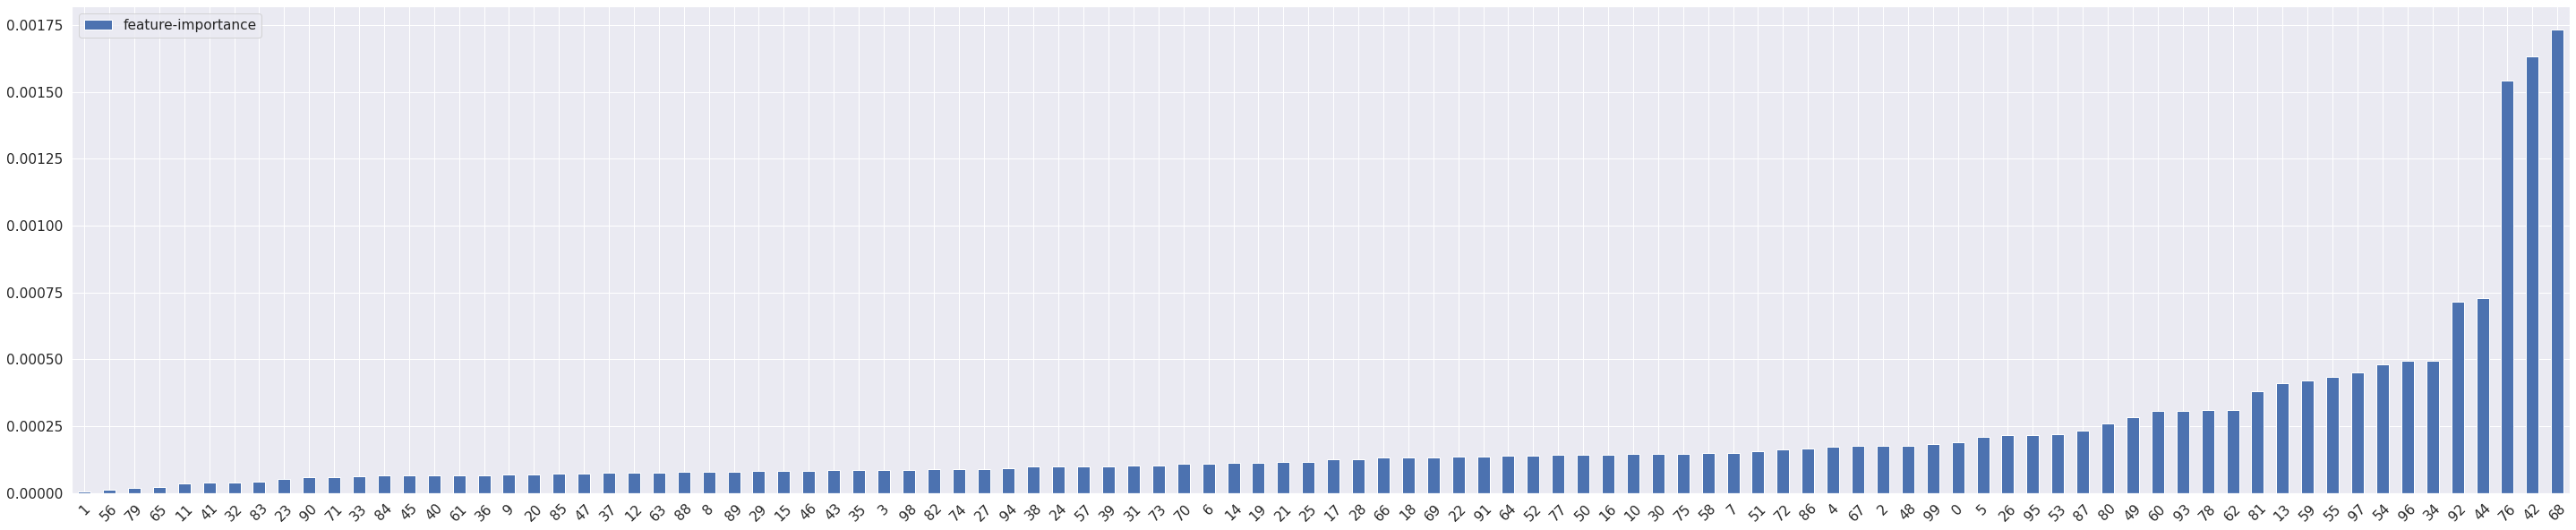

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, importances):
    feats[feature] = importance #add the name/value pair 

imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature-importance'})
imp.sort_values(by='feature-importance').plot(kind='bar', figsize=(50, 10), rot=45)

In [ ]:
print(adata.var_names[68])

SESN2


**Feature importance based on mean decrease in impurity**: This approach directly measures feature importance by observing how random re-shuffling (thus preserving the distribution of the variable) of each predictor influences model performance. 

(100,)
(10,)


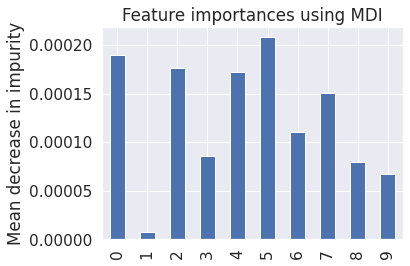

In [ ]:
import pandas as pd

forest_importances = pd.Series(importances, index=None) #series containing importances of each feature
print(forest_importances.shape)
top_importances = forest_importances.take([0,1,2,3,4,5,6,7,8,9], axis = 0) #take the top ten importances from the pandas series
print(top_importances.shape)

fig, ax = plt.subplots()
top_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Permutation feature importance**: The permutation feature importance is defined to compute how much each feature contributes to decreasing the weighted impurity. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. [Check out full explanation here](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)

In [ ]:
print(forest_importances)

0     0.000190
1     0.000007
2     0.000176
3     0.000086
4     0.000173
        ...   
95    0.000218
96    0.000493
97    0.000451
98    0.000088
99    0.000183
Length: 100, dtype: float64


https://www.datacamp.com/tutorial/random-forests-classifier-python

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, figsize=(20, 10))
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
#fig.tight_layout()
plt.show()

In [ ]:
#run this on a single cell
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
rf.feature_importances_